In [2]:
import pandas as pd
import numpy as np
import os
import sys
from tqdm.notebook import tqdm, trange

# librosa is a Python library for analyzing audio and music. It will be used to extract the data from the audio files
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from joblib import dump, load

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data Preparation

In [3]:
# Paths for data.
Ravdess = "D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/Ravdess/"
Crema = "D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/CREMA-D/AudioWAV/"
Tess = "D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS/"
Savee = "D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/savee/AudioData/"

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
1,neutral,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
2,neutral,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
3,neutral,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
4,calm,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...


crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

In [6]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for file in tess_directory_list:
    part = file.split('.')[0]
    part = part.split('_')[2]
    if part=='ps':
        file_emotion.append('surprise')
    else:
        file_emotion.append(part)
    file_path.append(Tess + '/' + file)
    print(Tess + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_back_angry.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_back_disgust.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_back_fear.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_back_happy.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_back_neutral.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_back_ps.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_back_sad.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_bar_angry.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_bar_disgust.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//OAF_bar_fear.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detec

D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_learn_angry.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_learn_disgust.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_learn_fear.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_learn_happy.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_learn_neutral.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_learn_ps.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_learn_sad.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_lease_angry.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_lease_disgust.wav
D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/TESS//YAF_lease_fear.wav
D:/Schmiede/Coding/IIS_Seminar/

,Emotions,Path
0,angry,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
1,disgust,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
2,fear,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
3,happy,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
4,neutral,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...


In [7]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for dir in savee_directory_list:
    directories = os.listdir(Savee + dir)
    for file in directories:
        file_path.append(Savee + dir + '/' + file)
        #part = file.split('_')[1]
        ele = file[:-6]
        if ele=='a':
            file_emotion.append('angry')
        elif ele=='d':
            file_emotion.append('disgust')
        elif ele=='f':
            file_emotion.append('fear')
        elif ele=='h':
            file_emotion.append('happy')
        elif ele=='n':
            file_emotion.append('neutral')
        elif ele=='sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
1,angry,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
2,angry,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
3,angry,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
4,angry,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...


In [8]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Savee_df, Tess_df], axis = 0) #,Crema_df
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
1,neutral,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
2,neutral,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
3,neutral,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...
4,calm,D:/Schmiede/Coding/IIS_Seminar/emotion-detecti...



# Data Visualisation and Exploration


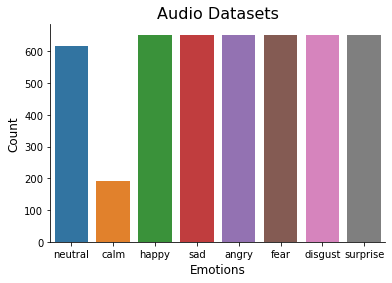

In [9]:
plt.title('Audio Datasets', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


# Data Augmentation


In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)


# Feature Extraction


In [11]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [12]:
X, Y = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions), total=len(data_path.Path)):
    #if emotion in ['angry','happy','fear','sad']:      #filter emotions
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [13]:
len(X), len(Y), data_path.Path.shape

(14160, 14160, (4720,))

In [14]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features_8.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.199840,0.634177,0.649343,0.628362,0.638806,0.659605,0.656050,0.692848,0.725562,0.746418,...,6.329699e-17,5.652504e-17,5.750069e-17,6.867979e-17,7.145225e-17,6.062353e-17,6.379936e-17,6.604256e-17,5.636582e-17,neutral
1,0.376564,0.849740,0.861379,0.857503,0.862682,0.839642,0.724167,0.729069,0.757324,0.786072,...,1.347566e-04,1.381011e-04,1.393141e-04,1.407071e-04,1.488192e-04,1.405207e-04,1.401091e-04,1.314167e-04,1.372978e-04,neutral
2,0.209196,0.612884,0.657517,0.671821,0.641508,0.665220,0.685169,0.692889,0.750290,0.761030,...,6.233610e-13,5.517969e-13,5.151515e-13,5.207072e-13,4.663090e-13,4.590219e-13,4.459034e-13,4.395373e-13,4.356802e-13,neutral
3,0.222209,0.667174,0.710842,0.698700,0.684300,0.719265,0.731313,0.729764,0.773791,0.792444,...,1.228669e-15,7.946725e-16,5.232372e-16,3.617297e-16,2.540173e-16,1.898123e-16,1.339943e-16,1.045975e-16,9.460106e-17,neutral
4,0.373081,0.837129,0.850292,0.835717,0.853030,0.820544,0.699672,0.719125,0.762959,0.779816,...,1.532929e-04,1.534762e-04,1.470145e-04,1.427629e-04,1.520439e-04,1.512296e-04,1.500445e-04,1.455549e-04,1.425984e-04,neutral



# Data Preparation


In [15]:
Features = pd.read_csv('features_8.csv')
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [16]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [17]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162), (10620, 8), (3540, 162), (3540, 8))

In [35]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

#dump(scaler, 'std_scaler_8.bin', compress=True)

['std_scaler_8.bin']

In [19]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162, 1), (10620, 8), (3540, 162, 1), (3540, 8))


# Modelling


In [23]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 81, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 128)          

In [26]:
########### only to test settings!########################
def cnn2(X_train, y_train):
    model = Sequential()
    model.add(Conv1D(256, 4, padding='same', input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
    model.add(Activation('relu'))
    model.add(Conv1D(256, 4, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 4, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 4, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 4, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 4, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(64, 4, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 4, padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1])) # Target class number
    model.add(Activation('softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

In [27]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[callback])

Epoch 1/50
166/166 [==============================] - 13s 80ms/step - loss: 0.1428 - accuracy: 0.9488 - val_loss: 0.5819 - val_accuracy: 0.8582
Epoch 2/50
166/166 [==============================] - 16s 96ms/step - loss: 0.1434 - accuracy: 0.9460 - val_loss: 0.5672 - val_accuracy: 0.8551
Epoch 3/50
166/166 [==============================] - 16s 99ms/step - loss: 0.1384 - accuracy: 0.9521 - val_loss: 0.5717 - val_accuracy: 0.8588
Epoch 4/50
166/166 [==============================] - 16s 98ms/step - loss: 0.1291 - accuracy: 0.9549 - val_loss: 0.5778 - val_accuracy: 0.8605
Epoch 5/50
166/166 [==============================] - 16s 98ms/step - loss: 0.1221 - accuracy: 0.9569 - val_loss: 0.6060 - val_accuracy: 0.8596
Epoch 6/50
166/166 [==============================] - 16s 98ms/step - loss: 0.1181 - accuracy: 0.9584 - val_loss: 0.5887 - val_accuracy: 0.8534
Epoch 7/50
166/166 [==============================] - 16s 98ms/step - loss: 0.1172 - accuracy: 0.9592 - val_loss: 0.5753 - val_accuracy:

111/111 [==============================] - 2s 15ms/step - loss: 0.6620 - accuracy: 0.8695
Accuracy of our model on test data :  86.94915175437927 %


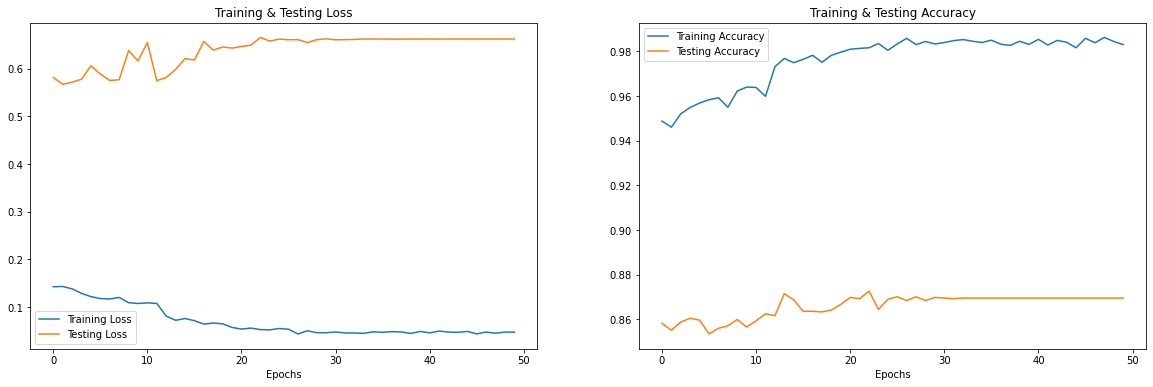

In [28]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [29]:
# predicting on test data.
pred_test = model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [30]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,happy,happy
1,fear,fear
2,surprise,surprise
3,angry,angry
4,happy,happy
5,happy,happy
6,neutral,neutral
7,surprise,surprise
8,happy,fear
9,disgust,disgust


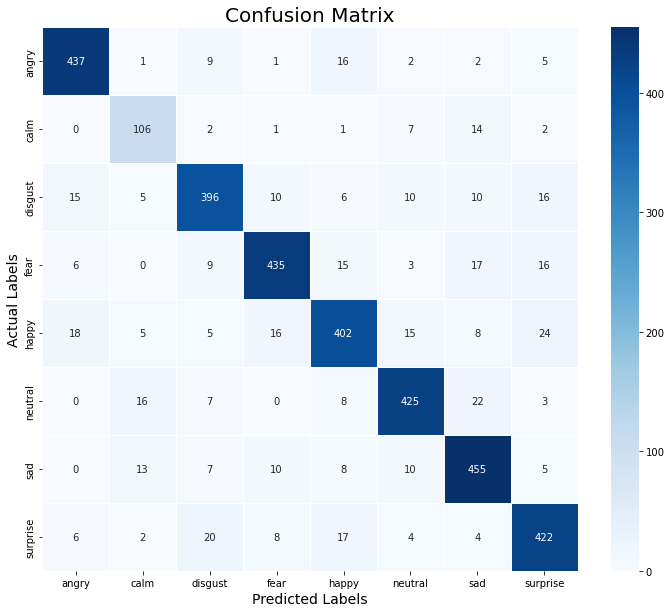

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [32]:
print(classification_report(y_test, y_pred))
model.save('SER_model_all8_without_CREMA.h5_ES')

              precision    recall  f1-score   support

       angry       0.91      0.92      0.92       473
        calm       0.72      0.80      0.75       133
     disgust       0.87      0.85      0.86       468
        fear       0.90      0.87      0.89       501
       happy       0.85      0.82      0.83       493
     neutral       0.89      0.88      0.89       481
         sad       0.86      0.90      0.87       508
    surprise       0.86      0.87      0.86       483

    accuracy                           0.87      3540
   macro avg       0.86      0.86      0.86      3540
weighted avg       0.87      0.87      0.87      3540



--------------------------------------------------------------------------------------
Use the part below to test the trained model.

In [33]:
#PREPARE
import speech_recognition as sr
import librosa as lb
from joblib import dump, load
scaler = load('std_scaler.bin')  #load pretrained SciKit StandardScaler
r = sr.Recognizer()
model = keras.models.load_model('SER_model_all8_without_CREMA.h5_ES')

In [34]:
#for i in range(5):
#    with sr.Microphone() as source:
#        print("Say something!")
#        audio = r.listen(source)
#    with open("microphone-results.wav", "wb") as f:
#        f.write(audio.get_wav_data())
    
#X, sample_rate = lb.load('D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/Ravdess/Actor_03/03-01-01-01-01-01-03.wav')
#plt.figure(figsize=(8, 4))
#lb.display.waveshow(X, sr=sample_rate)
#plt.title('Waveplot - Male Neutral')
#plt.show()


x_audio = get_features('D:/Schmiede/Coding/IIS_Seminar/emotion-detection-and-reaction/SER/data/savee/AudioData/JE/h08.wav')
x_audio = scaler.transform(x_audio)
x_audio = np.expand_dims(x_audio, axis=2)
pred = model.predict(x_audio)
#pred = encoder.inverse_transform(pred)
#print(np.argmax(pred[0]))
j=[]
for i in range(3):
    j.append(np.argmax(pred[i]))
counts = np.bincount(j)
print(np.argmax(counts))
#0:angry, 1:fear, 2:happy, 3:sad

2
